#Import all the important libraries

In [ ]:
## import commands of different important libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image

# import command for sequential layer
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import ResNet50

# dense,flaten and pooling layers
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop,Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the CSV file of the dataset for labels using Numpy

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/kaggle-medicine/Training_set.csv')

In [ ]:
df

,filename,label
0,Image_1.jpg,Bioflu
1,Image_2.jpg,Bactidol
2,Image_3.jpg,Fish Oil
3,Image_4.jpg,Fish Oil
4,Image_5.jpg,Bioflu
...,...,...
6995,Image_6996.jpg,Alaxan
6996,Image_6997.jpg,DayZinc
6997,Image_6998.jpg,Medicol
6998,Image_6999.jpg,Bactidol


# Checking if there are any null values in the dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  7000 non-null   object
 1   label     7000 non-null   object
dtypes: object(2)
memory usage: 109.5+ KB


#Run this if you want to divide your dataset properly into class in a folder

In [ ]:
#run this if you want to divide your dataset properly into class in a folder

csv_file_path = '/content/drive/MyDrive/kaggle-medicine/Training_set.csv'
df = pd.read_csv(csv_file_path)


source_directory = '/content/drive/MyDrive/kaggle-medicine/train'


for index, row in df.iterrows():
    image_name = row['filename']
    folder_name = row['label']

    destination_folder = os.path.join(source_directory, folder_name)
    os.makedirs(destination_folder, exist_ok=True)

    source_path = os.path.join(source_directory, image_name)
    destination_path = os.path.join(destination_folder, image_name)

    shutil.move(source_path, destination_path)

print("Image organization completed.")


In [ ]:
# checking Image size

image_path = "/content/drive/MyDrive/kaggle-medicine/train/Alaxan/Image_1003.jpg"
image = Image.open(image_path)

image_size = image.size

print(f"Image size: {image_size}")


Image size: (300, 300)


# Deep Learning Model Parameters

In [ ]:
BATCH_SIZE =52
IMAGE_SIZE = 300
CHANNELS=3

In [ ]:
# Load your dataset using keras
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/kaggle-medicine/XYZ",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 7000 files belonging to 10 classes.


In [ ]:
# check the class namnes in dataset
class_names = dataset.class_names
class_names

['Alaxan',
 'Bactidol',
 'Bioflu',
 'Biogesic',
 'DayZinc',
 'Decolgen',
 'Fish Oil',
 'Kremil S',
 'Medicol',
 'Neozep']

In [ ]:
#check for image batch shape
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)

(52, 300, 300, 3)


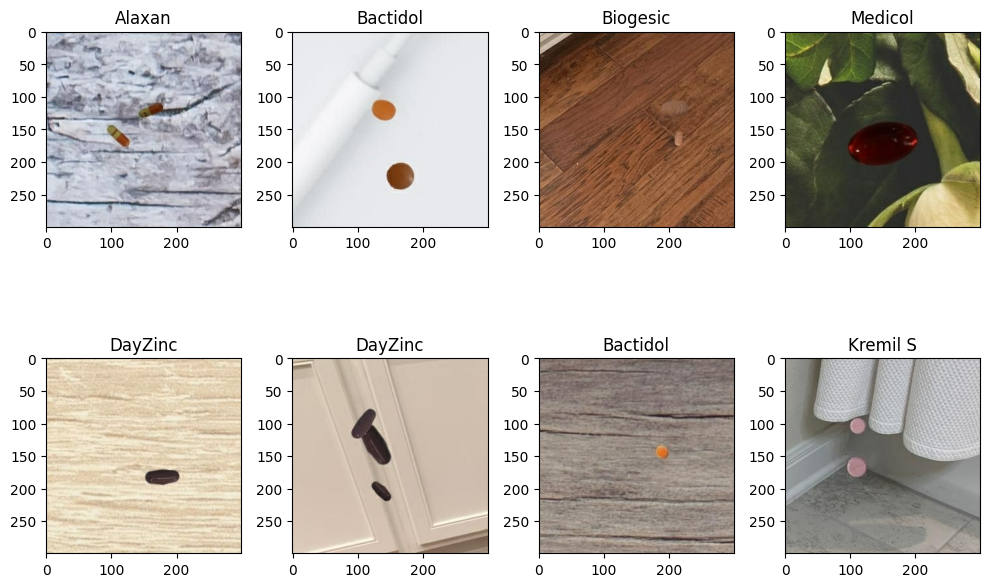

In [ ]:
# plot random images from the folder
plt.figure(figsize=(10, 10))
num_images_to_plot = 8

for _ in range(num_images_to_plot):
    image_batch, label_batch = next(iter(dataset))
    num_images_in_batch = image_batch.shape[0]
    random_index = np.random.randint(0, num_images_in_batch)
    ax = plt.subplot(3, 4, _ + 1)
    plt.imshow(image_batch[random_index].numpy().astype('uint8'))
    plt.title(class_names[label_batch[random_index]])

plt.tight_layout()
plt.show()

In [ ]:
# divide the dataset into training and validation

def get_data_partition(ds,training_size=0.8,val_size=0.2):
  # taking length of dataset
  len_ds=len(ds)

  # taking length of partition
  training=int(len_ds*training_size)
  val=int(len_ds*val_size)
   ## Taking values of partition
  train_ds=ds.take(training)
  val_ds=ds.skip(training).take(val)

  return train_ds, val_ds

In [ ]:
train_ds, val_ds = get_data_partition(dataset)

In [ ]:
# importing resizing and rescaling using keras
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
# Apply the resizing and rescaling on train_ds and val_ds
train_ds = train_ds.map(
    lambda x, y: (resize_and_rescale(x, training=True), y)
    )

val_ds= val_ds.map(
    lambda x, y: (resize_and_rescale(x, training=True), y)
    )

# CNN Model

In [ ]:
# CNN Model

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes =10
def Model(train,val):
    model = models.Sequential([
    # resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),


    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),


    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),


    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax')])

    model.build(input_shape=input_shape)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    with tf.device('/device:GPU:0'):
        history = model.fit(train, validation_data=val, batch_size=BATCH_SIZE, epochs=25)

    return model, history

In [ ]:
CNN_Model, history =Model(train_ds,val_ds)

Epoch 1/25
108/108 [==============================] - 25s 207ms/step - loss: 2.3040 - accuracy: 0.0956 - val_loss: 2.3031 - val_accuracy: 0.0882
Epoch 2/25
108/108 [==============================] - 24s 212ms/step - loss: 2.2806 - accuracy: 0.1010 - val_loss: 2.1253 - val_accuracy: 0.1286
Epoch 3/25
108/108 [==============================] - 24s 212ms/step - loss: 1.9770 - accuracy: 0.2215 - val_loss: 1.8984 - val_accuracy: 0.2717
Epoch 4/25
108/108 [==============================] - 23s 208ms/step - loss: 1.6562 - accuracy: 0.3291 - val_loss: 1.4718 - val_accuracy: 0.4140
Epoch 5/25
108/108 [==============================] - 22s 200ms/step - loss: 1.3565 - accuracy: 0.4250 - val_loss: 1.3007 - val_accuracy: 0.4350
Epoch 6/25
108/108 [==============================] - 23s 209ms/step - loss: 1.2182 - accuracy: 0.4724 - val_loss: 1.1703 - val_accuracy: 0.5051
Epoch 7/25
108/108 [==============================] - 24s 212ms/step - loss: 1.1222 - accuracy: 0.5080 - val_loss: 1.2356 - val_ac

In [ ]:
# saving CNN model
CNN_Model.save("/content/drive/MyDrive/kaggle-medicine/Visual/CNN_Model.h5")

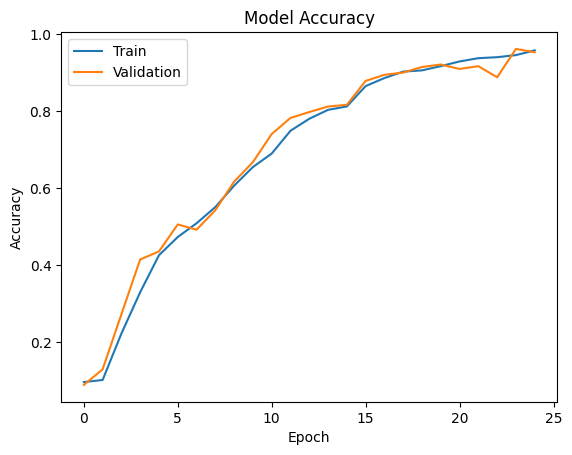

In [ ]:
# Plotting Trainign accuracy and validation accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# saving training history of the model using numpy

np.save('/content/drive/MyDrive/kaggle-medicine/Visual/CNN_training_history.npy', history.history)

In [ ]:
CNN_eval = CNN_Model.evaluate(val_ds)

print("VGG19 Model Accuracy:", CNN_eval[1])

27/27 [==============================] - 13s 77ms/step - loss: 0.2188 - accuracy: 0.9501
VGG19 Model Accuracy: 0.9501445293426514


# VGG19 Model

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models

def create_vgg19_model(input_shape, num_classes):
    # Load VGG19 model without the fully connected layers
    vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

    vgg19_base.trainable = False

    # Add custom fully connected layers
    flatten_layer = layers.Flatten()(vgg19_base.output)
    dense_layer = layers.Dense(512, activation='relu')(flatten_layer)
    output_layer = layers.Dense(num_classes, activation='softmax')(dense_layer)

    # Create the model
    model = models.Model(inputs=vgg19_base.input, outputs=output_layer)

    return model

# Define input shape and number of classes
input_shape = (300, 300, 3)
num_classes = 10

# Create VGG19 model
vgg19_model = create_vgg19_model(input_shape, num_classes)

# Compile the model
vgg19_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# Display model summary
vgg19_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0   

In [ ]:
with tf.device('/device:GPU:0'):
  history12 = vgg19_model.fit(train_ds, validation_data=val_ds, batch_size=BATCH_SIZE, epochs=25)

Epoch 1/25
108/108 [==============================] - 35s 307ms/step - loss: 3.3170 - accuracy: 0.3358 - val_loss: 1.5015 - val_accuracy: 0.5130
Epoch 2/25
108/108 [==============================] - 33s 303ms/step - loss: 1.0558 - accuracy: 0.6654 - val_loss: 1.1968 - val_accuracy: 0.5975
Epoch 3/25
108/108 [==============================] - 34s 304ms/step - loss: 0.7404 - accuracy: 0.7721 - val_loss: 0.9313 - val_accuracy: 0.6871
Epoch 4/25
108/108 [==============================] - 34s 305ms/step - loss: 0.5542 - accuracy: 0.8405 - val_loss: 0.8876 - val_accuracy: 0.7016
Epoch 5/25
108/108 [==============================] - 33s 303ms/step - loss: 0.4168 - accuracy: 0.8839 - val_loss: 0.7744 - val_accuracy: 0.7673
Epoch 6/25
108/108 [==============================] - 33s 299ms/step - loss: 0.3244 - accuracy: 0.9197 - val_loss: 0.7530 - val_accuracy: 0.7543
Epoch 7/25
108/108 [==============================] - 33s 303ms/step - loss: 0.3070 - accuracy: 0.9147 - val_loss: 0.8249 - val_ac

In [ ]:
vgg19_model.save("/content/drive/MyDrive/kaggle-medicine/Visual/VGG19_model3.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
np.save('/content/drive/MyDrive/kaggle-medicine/Visual/vgg19_training_history3.npy', history12.history)

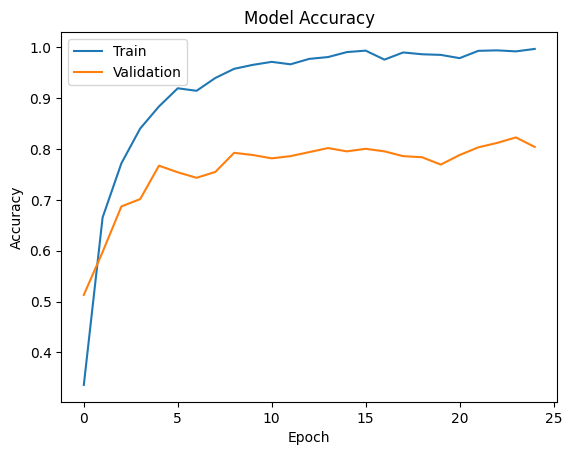

In [ ]:
plt.plot(history12.history['accuracy'])
plt.plot(history12.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# InceptionResnetv2 Model

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras import layers, models

def create_inceptionresnetv2_model(input_shape, num_classes):
    # Load InceptionResNetV2 with pre-trained weights
    inceptionresnetv2_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


    for layer in inceptionresnetv2_model.layers:
        layer.trainable = False


    x = layers.GlobalAveragePooling2D()(inceptionresnetv2_model.output)
    x = layers.Dense(512, activation='relu')(x)
    output_layer = layers.Dense(num_classes, activation='softmax')(x)


    model = models.Model(inputs=inceptionresnetv2_model.input, outputs=output_layer)

    return model

# Example usage:
input_shape = (300, 300, 3)
n_classes = 10
inceptionresnetv2_model = create_inceptionresnetv2_model(input_shape, n_classes)
inceptionresnetv2_model.compile(optimizer='adam',
                                loss='sparse_categorical_crossentropy',
                                metrics=['accuracy'])


inceptionresnetv2_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d_6[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0]

In [ ]:
history2 = inceptionresnetv2_model.fit(train_ds, validation_data=val_ds, batch_size=BATCH_SIZE, epochs=25)

Epoch 1/25
108/108 [==============================] - 54s 362ms/step - loss: 1.4197 - accuracy: 0.5242 - val_loss: 1.0464 - val_accuracy: 0.6402
Epoch 2/25
108/108 [==============================] - 34s 311ms/step - loss: 0.8482 - accuracy: 0.7174 - val_loss: 0.7882 - val_accuracy: 0.7290
Epoch 3/25
108/108 [==============================] - 35s 314ms/step - loss: 0.7085 - accuracy: 0.7530 - val_loss: 0.7607 - val_accuracy: 0.7399
Epoch 4/25
108/108 [==============================] - 35s 314ms/step - loss: 0.6285 - accuracy: 0.7804 - val_loss: 0.6988 - val_accuracy: 0.7507
Epoch 5/25
108/108 [==============================] - 35s 315ms/step - loss: 0.5560 - accuracy: 0.8091 - val_loss: 0.6812 - val_accuracy: 0.7717
Epoch 6/25
108/108 [==============================] - 35s 313ms/step - loss: 0.5318 - accuracy: 0.8175 - val_loss: 0.6206 - val_accuracy: 0.7868
Epoch 7/25
108/108 [==============================] - 35s 315ms/step - loss: 0.4526 - accuracy: 0.8456 - val_loss: 0.6431 - val_ac

In [ ]:
inceptionresnetv2_model.save("/content/drive/MyDrive/kaggle-medicine/Visual/Inceptionresnetv2_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
np.save('/content/drive/MyDrive/kaggle-medicine/Visual/inceptionresnetv2_training_history.npy', history2.history)